In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
from scipy import stats
import itertools as it

import glob
import os

<img src="./../images/kitten.jpg" align="right" width="320" />

Hi, comrades! 

Consider an ordinary online experiment in some company named "Mustaches and Claws." They have a web site that has a red button in the form of a rectangle with rounded edges. If the user clicks on this button, then  one kitten somewhere in the world purrs with joy. The task of the company is to maximize the humming. There is also a marketing department that diligently investigates the shape of the buttons and how they affect the conversion of the cliche-purring hits. Spending almost the entire company's budget for unique research, marketing was divided into four opposing factions. Each group has its own brilliant idea of ​​what a button should look like. In general, no one is against the shape of the button, but the red annoys all marketers, and four alternative options have been proposed. In fact, not so important, even what options, we are interested in the option that maximizes the humming. Marketing suggests conducting an A / B / n test, but we do not agree, and so on these questionable studies, money is immersed immeasurably. Let's try to make as many kittens as possible and save on traffic. To optimize the traffic sent to the tests, we will use a gang of multi-armed bayesian bandits (bayesian multi-armed bandits). Forward.



Рассмотрим обычный онлайн эксперимент в некоторой компании "Усы и когти". У них есть веб сайт, на котором есть красная кнопка, в форме прямоугольника с закругленными краями. Если пользователь нажимает на эту кнопку, то где то в мире мурлычет от радости один котенок. Задача компании максимизация мырлыкания. Так же есть отдел маркетинга, который усердно исследует формы кнопок и то, как они влияют на конверсию показов в клико-мурлыкания. Потратив почти весь бюджет компании на уникальные исследования, маркетинг разделился на четыре противоборствующие группировоки. У каждой группировки есть своя гениальная идея того, как должна выглядеть кнопка. В целом никто не против формы кнопки, но красный раздражает всех маркетологов, и было предложенно четыре альтернативных варианта. На самом деле не так важно даже какие варианты, нас интересует тот вариант, который максимизирует мырлыкания. Маркетинг предлагает провести A/B/n тест, но мы не согласны, и так на эти сомнительные исследования спущено денег немеренно. Попробуем осчастливить как можно больше котят и сэкономить на трафике. Для оптимизации трафика, пущенного на тесты, мы будет использовать шайку многоруких байесовских бандитов (bayesian multi-armed bandits). Вперед.

# A/B/n тест

Будем считать, что клик - это некоторая случайная переменная $k$, принимающая значения  $0$ или $1$, с вероятностью $\theta$ и $1 - \theta$ соответственно. Такая величина имеет распределение Бернулли с параметром $\theta$:

$$\large 
\begin{array}{rcl}
k &\sim& \text{Bernoulli}\left(\theta\right) \\
p\left(k = 1\right) &=& \theta^k \left(1 - \theta\right)^{1 - k}
\end{array}
$$

Вспомним, что среднее значение распределения Бернулли равно $\mu = \theta$, а дисперсия равна $\sigma^2 = \theta\left(1 - \theta\right)$.

Попробуем для начала решить проблему с помощью обычного A/B/n теста, n здесь означает, что тестируются не две гипотезы, а несколько. В нашем случае это пять гипотез. Но мы рассмотрим сначала ситуацию тестирования старого решения против нового, а затем обобщим на все пять случаев. В бинарном случае у нас есть две гипотезы:
- нулевая гипотеза $H_0: \theta_c = \theta_t$ заключается в том, что нет никакой разницы в вероятностью клика по старой кнопке $\theta_c$ и или по новой $\theta_t$;
- альтернативная гипотеза $H_1: \theta_c < \theta_t$ заключается в том, что вероятностью клика по старой кнопке $\theta_c$ меньше чем по новой $\theta_t$;
- вероятности $\theta_c$ и $\theta_t$ мы оцениваем как отношение кликов к показам на контролькой группе (control) и экспериментальной/тестовой группе (treatment) соответственно.

Мы не можем знать истинное значение конверсии $\theta_c$ на текущей вариации кнопки (на красной), но мы можем его оценить. Для этого у нас есть два механизма, которые работаю сообща. Во-первых, <a href="https://ru.wikipedia.org/wiki/Закон_больших_чисел">закон больших чисел</a>, который утверждает, что какое бы не было распределение случайной величины, если мы посемплируем достаточное количество примеров и усредним, то такая оценка будет близка к истинному значению среднеднего значения распределения (опустим пока индекс $c$ для ясности):

$$\large
\begin{array}{rcl}
\overline{\theta}_n &=& \frac{1}{n}\sum_{i=1}^n k_i \\
\forall \epsilon \in \mathbb{R}: \lim_{n \rightarrow \infty} &=& P\left(\left|\overline{\theta}_n - \mu\right| < \epsilon\right) = 1
\end{array}
$$

Во-вторых, <a href="https://ru.wikipedia.org/wiki/Центральная_предельная_теорема">центральная предельная теорема</a>, которая утверждает следующее. Допустим есть бесконечный ряд независимых и одинаково распределенных случайных величин $k_1, k_2, \ldots$, с истинным матожиданием $\mu$ и дисперсией $\sigma^2$. Обозначим конечную сумму как $S_n = \sum_{i}^n k_i$, тогда

$$\large
\frac{S_n - \mu}{\sigma\sqrt{n}} \rightarrow \mathcal{N}\left(0, 1\right)\text{ при }n \rightarrow \infty
$$

или эквивалентно, тому, что при достаточно больших выборках оценка среднего значения имеет нормальное распределение с центром в $\mu$ и дисперсией $\frac{\sigma^2}{n}$:

$$\large
\overline{\theta} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)
$$

Казалось бы бери да запускай два теста: раздели трафик на две части, жди пару дней, и сравнивай средние значения кликов по первому механизму. Второй механизм позволяет нам применять <a href="https://ru.wikipedia.org/wiki/T-Критерий_Стьюдента">t-тест</a> для оценки статистической значимости разницы средних значений выборок (потому что оценки средних имеют нормальное распределение). А так же, увеличивая размер выборки $n$, мы уменьшаем дисперсию оценки среднего, тем самым увеличивая свою уверенность. Но остается один важный вопрос: а какое количество трафика (пользователей) пустить на каждуй вариацию кнопки. Статистика нам говорит, что если разница не нулевая, то это еще совсем не значит, что значения не равны. Возможно не повезло просто и первые $70\%$ пользователей люто ненавидели какой то цвет, и нужно подождать еще. И возникает вопрос, а сколько пользователей пустить на каждую вариацию кнопки, что бы быть уверенным, что если разница и есть, то она существенная. Для этого нам придется еще раз встретиться с отделом маркетинга, и задать им несколько вопросов, и вероятно нам придется им объяснить, что такое ошибки первого и второго рода. В общем это может быть чуть ли не самым сложным во всем тесте. Итак, вспомним, что это за ошибки, и определим вопросы, которые следует задать отделу маркетинга, что бы оценить количество трафика на вариацию. В конечном счете именно маркетинг принимает окончательно решение о том, какой цвет кнопки оставить. 

<table>
<tr><td colspan=2 rowspan=2></td><td colspan=2>Верная гипотеза</td></tr>
<tr><td>$H_0$</td><td>$H_1$</td></tr>
<tr>
    <td rowspan=2>Ответ теста</td>
    <td>$H_0$</td>
    <td bgcolor="lightgreen">$H_0$ принята</td>
    <td bgcolor="LightCoral">$H_0$ неверно принята <br/> (ошибка II рода)</td>
</tr>
<tr>
    <td>$H_1$</td>
    <td bgcolor="LightCoral">$H_0$ неверно отвергнута <br/> (ошибка I рода)</td>
    <td bgcolor="lightgreen">$H_0$ отвергнута</td>
</tr>
</table>

Введем еще несколько понятий. Обозначим вероятность ошибки первого рода как $\alpha = P\left(H_1 \mid H_0\right)$, т.е. вероятность принятия альтернативной гипотезы, при условии, что на самом деле верна нулевая гипотеза. Эта величина называется статистической значимостью (statistical significance). Так же нам понадобидся ввести вероятность ошибки второго рода $\beta = P\left(H_0 \mid H_1\right)$. Величина $1 - \beta$ называется статистической мощностью (statistical power). 

Рассмотрим изображени ниже, что бы проиллюстрировать смысл статистической значимости и мощности. Предположим, что среднее значение распределения случайной величины на контрольной группе равно $\mu_c$, а на тестовой $\mu_t$. Выберем некоторый критический порог выше которого гипотеза $H_0$ отвергается (вертикальная зеленая линия). Тогда, если значение было правее порога, но из распределения контрольной группы, то мы его ошибочно припишем к распределению тестовой группы. Это будет ошибка первого рода, а значение $\alpha$ это прощадь закрашенная красным цветом. Соответственно, область закрашенная синим цветом равна $\beta$. Величина $1 - \beta$, которую мы назвали статистической мощностью, по сути это то, сколько значений соответствующих альтернативной гипотезе мы действительно отнесем к альтернативной гипотезе.

# A / B / n test

We assume that a click is some random variable $ k $ taking values ​​$ 0 $ or $ 1 $ with probability $ \ theta $ and $ 1 - \ theta $, respectively. Such a value has the Bernoulli distribution with the parameter $ \ theta $:

$$ \ large
\ Begin {array} {rcl}
K & \ sim & \ text {Bernoulli} \ left (\ theta \ right) \\
P \ left (k = 1 \ right) & = & \ theta ^ k \ left (1 - \ theta \ right) ^ {1 - k}
\ End {array}
$$

Recall that the average value of the Bernoulli distribution is equal to $ \ mu = \ theta $, and the variance is $ \ sigma ^ 2 = \ theta \ left (1 - \ theta \ right) $.

A / B / n test, n here means that not two hypotheses are tested, but several. In our case, these are five hypotheses. But we have considered first, and then we generalize all five cases. In the binary case, we have two hypotheses:
- the null hypothesis of $ H_0: \ theta_c = \ theta_t $ is that there is no difference in the probability clique for the old button $ \ theta_c $ and for the new $ \ theta_t $;
- the alternative hypothesis $ H_1: \ theta_c <\ theta_t $ is that the probability clique on the old button $ \ theta_c $ is less than the new $ \ theta_t $;
- We estimate the version of $ \ theta_c $ and $ \ theta_t $ as the ratio of clicks to impressions per control group (control) and experimental / test group (treatment), respectively.

We can not know the true value of the $ \ theta_c $ conversion on the current button variation (in red), but we can evaluate it. For this, we have two mechanisms that work together. First, <a href="https://en.wikipedia.org/wiki/Law_numbers""> the law of large numbers </a>, which states that any distribution of a random variable, if we simulate sufficient The number of examples AND is averaged, then such an estimate will be close to the true value of the mid-annual value of the distribution (we omit the index $ c $ for clarity):

$$ \ large
\ Begin {array} {rcl}
\ Overline {\ theta} _n & = & \ frac {1} {n} \ sum_ {i = 1} ^ n k_i \\
\ Forall \ epsilon \ in \ mathbb {R}: \ lim_ {n \ rightarrow \ infty} & = & P \ left (\ left | \ overline {\ theta} _n - \ mu \ right | <\ epsilon \ right) = 1.
\ End {array}
$$

Secondly, <a href="https://ru.wikipedia.org/wiki/Central_limit_theorem"> the central limit theorem </a>, which states the following. Assume there is an infinite series of independent and identically distributed random variables $ k_1, k_2, \ ldots $, with a true mathematical expectation $ \ mu $ and variance $ \ sigma ^ 2 $. We denote the finite sum as $ S_n = \ sum_ {i} ^ n k_i $, then

$$ \ large
\ Frac {S_n - \ mu} {\ sigma \ sqrt {n}} \ rightarrow \ mathcal {N} \ left (0, 1 \ right) \ text {for} n \ rightarrow \ infty
$$

Or it is equivalent to the fact that for sufficiently large samples, the average value estimate has a normal distribution centered at $ \ mu $ and the variance $ \ frac {\ sigma ^ 2} {n} $:

$$ \ large
\ Overline {\ theta} \ sim \ mathcal {N} \ left (\ mu, \ frac {\ sigma ^ 2} {n} \ right)
$$

It would seem that you need to run two tests: split the trace into two parts, wait a couple of days, and compare the average values ​​of clicks on the first mechanism. The second mechanism allows us to apply the <a href="https://en.wikipedia.org/wiki/T-Counter_Tester"> t-test </a> to assess the statistical significance of the difference in mean samples (because the estimates of the mean Have a normal distribution). And also, by increasing the sample size $ n $, we reduce the variance of the average estimate, thereby increasing our confidence. But there is one important question: how much traffic (users) to put on each variation of the buttons. Statistics tell us that if the difference is not zero, then it does not mean that the values ​​are not equal. Perhaps it was not so easy, and the first $ 70 \% $ users hate a certain color and you need to wait. And the question arises: how many users are allowed for each variation of the buttons, to be sure that if there is a difference, then it is significant. To do this, we need to split again with the marketing department, and ask them a few questions, and perhaps explain what are the mistakes of the first and second kind. In general, this can be almost the most difficult in the whole test. So, let's remember what those mistakes are, and we will define the questions that should be asked the marketing department to estimate the amount of traffic for the variation. In a particular case, it is marketing that requires a final decision on what color buttons to leave.

We introduce several more concepts. We denote the error probability of the first kind as $ \ alpha = P \ left (H_1 \ mid H_0 \ right) $, i.e. Probability of accepting an alternative hypothesis, provided that the null hypothesis is actually true. This value is called statistical significance. We also need to introduce the probability of an error of the second kind $ \ beta = P \ left (H_0 \ mid H_1 \ right) $. The value $ 1 - \ beta $ is called the statistical power.

Consider the images below to illustrate the meaning of statistical significance and power. Suppose that the mean value of the random variable distribution on the control group is $ \ mu_c $, and the test $ \ mu_t $. We choose some critical threshold above which the hypothesis $ H_0 $ is rejected (vertical green line). Then, if the value was to the right of the threshold, but from the distribution of the control group, then we erroneously assign it to the distribution of the test group. This will be a first-order error, and the value of $ \ alpha $ is a red dotted area. Accordingly, the area shaded in blue is $ \ beta $. The value of $ 1 - \ beta $, which we called the statistical power, is essentially how many values ​​of the corresponding alternative hypothesis we really attribute to the alternative hypothesis.

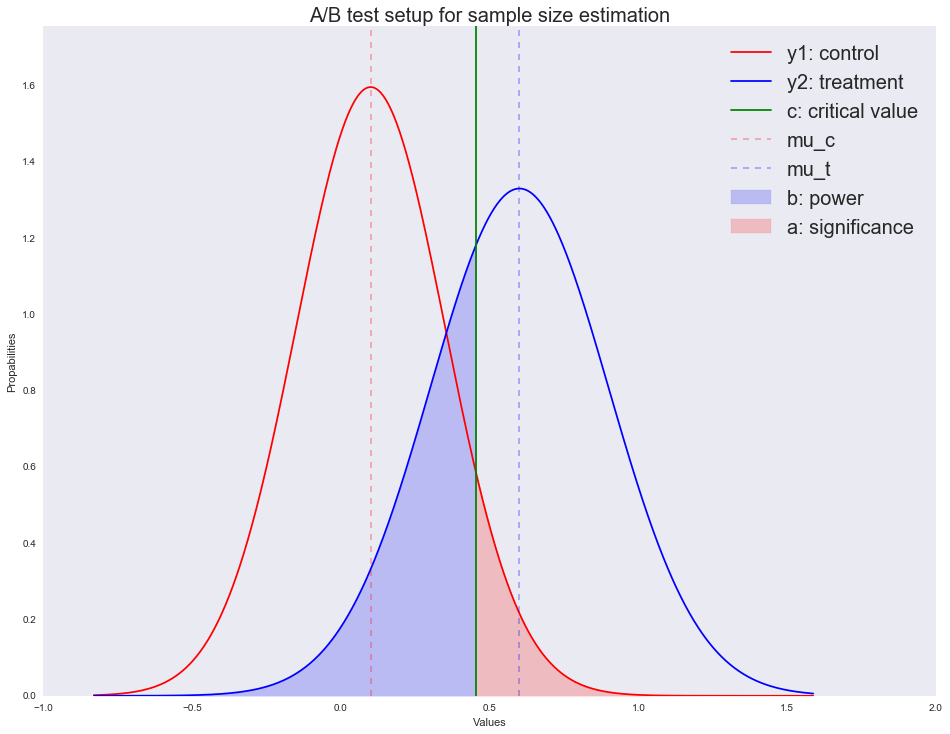

In [10]:
# Mean values of two distributions 
mu_c = 0.1
mu_t = 0.6

# Variances of two distributions 
s_c = 0.25
s_t = 0.3

# A threshold: if a value of observed variable is higher than a threshold,
# we take it to the blue-colored distribution
c = 1.3*(mu_c + mu_t)/2

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

Обозначим этот порог буквой $c$, то справедливо следующее равенствно, при условии, что случайная величина имеет нормальное распределение:

$$\large
c = \mu + t\frac{\sigma}{\sqrt{n}}
$$
где $t = P\left(X \leq t\right), X \sim \mathcal{N}\left(0, 1\right)$ - это <a href="https://ru.wikipedia.org/wiki/Функция_ошибок">квантильная функция</a>.

В нашем случае мы можем записать систему из двух уравнений для $\alpha$ и $\beta$ соответственно:

$$\large
\begin{array}{rcl}
c &=& \theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} \\
c &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}}
\end{array}
$$

Решив эту систему относительно $n$ мы получим оценку достаточного количества трафика, который необходимо загнать в каждый эксперимент при заданной статистической значимости и мощности. 

$$\large
\begin{array}{rcl}
\theta_c + t_{\alpha}\sqrt{\frac{\theta_c\left(1 - \theta_c\right)}{n}} &=& \theta_t + t_{\beta}\sqrt{\frac{\theta_t\left(1 - \theta_t\right)}{n}} \\
\theta_c \sqrt{n} + t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)} &=& \theta_t \sqrt{n} + t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} \\
n &=& \left(\frac{t_{\beta}\sqrt{\theta_t\left(1 - \theta_t\right)} - t_{\alpha}\sqrt{\theta_c\left(1 - \theta_c\right)}}{\theta_c - \theta_t}\right)^2
\end{array}
$$

Denote this threshold by the letter $ c $, then the following holds true, provided that the random variable has a normal distribution:

$$ \ large
C = \ mu + t \ frac {\ sigma} {\ sqrt {n}}
$$
Where $ t = P \ left (X \ leq t \ right), X \ sim \ mathcal {N} \ left (0, 1 \ right) $ is <a href = "https://en.wikipedia.org / Wiki / Error-function "> quantile function </a>.

In our case, we can write a system of two equations for $ \ alpha $ and $ \ beta $, respectively:

$$ \ large
\ Begin {array} {rcl}
C & = & \ theta_c + t_ {\ alpha} \ sqrt {\ frac {\ theta_c \ left (1 - \ theta_c \ right)} {n}} \\
C & = & \ theta_t + t_ {\ beta} \ sqrt {\ frac {\ theta_t \ left (1 - \ theta_t \ right)} {n}}
\ End {array}
$$

Solving this system with respect to $ n $, we obtain an estimate of the sufficient amount of traffic that must be driven into each experiment for a given statistical significance and power.

$$ \ large
\ Begin {array} {rcl}
\ Theta_c + t_ {\ alpha} \ sqrt {\ frac {\ theta_c \ left (1 - \ theta_c \ right)} {n}} & = & \ theta_t + t_ {\ beta} \ sqrt {\ frac {\ theta_t \ Left (1 - \ theta_t \ right)} {n}} \\
\ Theta_c \ sqrt {n} + t_ {\ alpha} \ sqrt {\ theta_c \ left (1 - \ theta_c \ right)} & = & \ theta_t \ sqrt {n} + t_ {\ beta} \ sqrt {\ theta_t \ Left (1 - \ theta_t \ right)} \\
N \ = \ \ left (\ frac {t_ {\ beta} \ sqrt {\ theta_t \ left (1 - \ theta_t \ right)} - ​​t_ {\ alpha} \ sqrt {\ theta_c \ left (1 - \ theta_c \ Right)}} {\ theta_c - \ theta_t} \ right) ^ 2
\ End {array}
$$


Например, если реальное значение конверсии $0.001$, а новое $0.0011$, тогда при $\alpha = \beta = 0.01$ нам необходимо прогнать **2 269 319** пользователей через каждую вариацию. А новая вариация будет принята в случае если ее конверсия привысит $0.00104$.

For example, if the actual conversion value is $ 0.001 $, and the new one is $ 0.0011 $, then for $ \ alpha = \ beta = 0.01 $ we need to run ** 2 269 319 ** users through each variation. A new variation will be adopted if its conversion is used to $ 0.00104 $.

In [3]:
def get_size(theta_c, theta_t, alpha, beta):
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

n_max = get_size(0.001, 0.0011, 0.01, 0.01)
print n_max
print 0.001 + stats.norm.ppf(1 - 0.01, loc=0, scale=1)*np.sqrt(0.001*(1 - 0.001)/n_max)

2269319
0.00104881009215


Таким образом, что бы вычислить эффективный размер выборки, мы должны пойти в маркетинг или другой бизнес департамент и узнать у них следующее:
- какое значение конверсии $\theta_t$ на новой вариации должно получиться, что бы бизнес принял решение перейти со старой версии кнопки с конверсией $\theta_c$ на новую;
- какой допустимый уровень значимости $\alpha$ и мощности $\beta$ необходим (вероятно тут еще придется как то объяснить бизнесу что это значит).

Получив $n$ мы можем легко вычислить порог $c$. Это значит, что если мы соберем $n$ наблюдейний для каждой вариации, и окажется, что в экспериментальной группе оценка клика $\theta_t$ выше порога $c$, то мы отклняем $H_0$ и принимаем альтернативную гипотезу $H_1$, о том что новая вариация лучше и вероятно мы ее внедрим. В этом случае у нас будет $\alpha \cdot 100\%$ шансов ошибки первого рода, т.е. мы ошибочно приняли решение заменить старую кнопку на новую. И $\left(1 - \beta\right)\cdot 100\%$ шансов, что если новая вариация лучше, то мы правильно и сделали, что ее внедрили. Но самое печальное в том, что если после эксперимента, когда мы прогнали трафик через две вариации, окажется, что $\theta_t < c$, то мы считаем, что нет оснований отказываться от старой кнопки. Именно нет основания, мы не доказали, что новая кнопка хуже, мы как были в неопределенности, так и остались. Такие дела.

Честно говоря, мне кажется что выводы полученные в предыдущем абзаце не очень убедительны, и вообще могут запутать не только вас. Представьте, отдел маркетинга потратил пару миллионов рублей на уникальные исследования новой формы кнопки, а вы им такой "нет оснований считать что она лучше". Кстати на счет оснований, давайте проиллюстрируем как решается уравнение относительно размера выборки, и как изменяются распределение оценки среднего значения при увеличении размера выборки. На анимации вы можете наблюдать, как при увеличении размера выборки, размах распределения оценки среднего уменьшается, т.е. уменьшается дисперсия оценки, которая и отождествляется с нашей уверенностью в этой оценки. На самом деле изображение ниже немного нечестное, при уменьшении размаха распределения, оно еще и увеличивается в высоту, т.к. площадь должна оставаться постоянной. Реальная анимация в спойлере, но она чуть менее очевидна. 

So, to calculate the effective sample size, we need to go to the marketing or other business department and find out from them the following:
- what is the value of the conversion $ \ theta_t $ on the new variation should be, that the business decided to switch from the old version of the button with the conversion $ \ theta_c $ to the new one;
- what permissible level of significance $ \ alpha $ and power $ \ beta $ is necessary (probably there will still have to be explained to the business what this means).

Having obtained $ n $, we can easily calculate the threshold $ c $. This means that if we collect $ n $ observations for each variation, and it turns out that in the experimental group the estimate of the click $ \ theta_t $ is higher than the threshold $ c $, then we turn off $ H_0 $ and accept the alternative hypothesis $ H_1 $, That the new variation is better and we will probably implement it. In this case, we will have $ \ alpha \ cdot 100 \% $ odds of error of the first kind, i.e. We mistakenly decided to replace the old button with a new one. And $ \ left (1 - \ beta \ right) \ cdot 100 \% $ chances that if the new variation is better, then we correctly did that it was implemented. But the saddest thing is that if after the experiment, when we drove traffic through two variations, it turns out that $ \ theta_t <c $, then we think that there is no reason to refuse the old button. There is no reason, we did not prove that the new button is worse, we were as uncertain as they were, and we stayed. So it goes.

Honestly, it seems to me that the conclusions obtained in the previous paragraph are not very convincing, and in general can confuse not only you. Imagine, the marketing department spent a couple of million rubles on the unique research of the new button shape, and you are such "there is no reason to think that it is better." By the way, on the basis of the bases, let's illustrate how the equation is solved with respect to the sample size, and how the distribution of the mean value estimate changes with increasing sample size. On the animation, you can see how, as the sample size increases, the distribution of the average estimate decreases; The dispersion of the estimate decreases, which is identified with our confidence in this estimate. In fact, the image below is a little dishonest, with a decrease in the distribution span, it also increases in height, because The area must remain constant. Real animation in the spoiler, but it's a little less obvious.

In [11]:
np.random.seed(1342)

p_c = 0.3 
p_t = 0.4
alpha = 0.05
beta = 0.2

n_max = get_size(p_c, p_t, alpha, beta)
c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*np.sqrt(p_c*(1 - p_c)/n_max)
print n_max, c


def plot_sample_size_frames(do_dorm, width, height):
    left_x = c - width
    right_x = c + width
    
    n_list = range(5, n_max, 1) + [n_max]
    for f in glob.glob("./../images/sample_size_gif/*_%s.*" % 
                       ('normed' if do_dorm else 'real')):
        os.remove(f)
    for n in tqdm_notebook(n_list):
        s_c = np.sqrt(p_c*(1 - p_c)/n)
        s_t = np.sqrt(p_t*(1 - p_t)/n)

        c_c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*s_c
        c_t = p_t + stats.norm.ppf(beta, loc=0, scale=1)*s_t

        support = np.linspace(left_x, right_x, 1000)
        y_c = stats.norm.pdf(support, loc=p_c, scale=s_c)
        y_t = stats.norm.pdf(support, loc=p_t, scale=s_t)
        if do_dorm:
            y_c /= max(y_c.max(), y_t.max())
            y_t /= max(y_c.max(), y_t.max())


        fig, ax = plt.subplots()
        ax.plot(support, y_c, color='r', label='y control')
        ax.plot(support, y_t, color='b', label='y treatment')

        ax.set_ylim(0, height)
        ax.set_xlim(left_x, right_x)

        ax.axvline(c, color='g', label='c')
        ax.axvline(c_c, color='m', label='c_c')
        ax.axvline(c_t, color='c', label='c_p')
        ax.axvline(p_c, color='r', alpha=0.3, linestyle='--', label='p_c')
        ax.axvline(p_t, color='b', alpha=0.3, linestyle='--', label='p_t')

        ax.fill_between(support[support <= c_t], 
                        y_t[support <= c_t], 
                        color='b', alpha=0.2, label='b: power')
        ax.fill_between(support[support >= c_c], 
                        y_c[support >= c_c], 
                        color='r', alpha=0.2, label='a: significance')

        ax.legend(loc='upper right', prop={'size': 20})

        ax.set_title('Sample size: %i' % n, fontsize=20)

        fig.savefig('./../images/sample_size_gif/%i_%s.png' % 
                    (n, 'normed' if do_dorm else 'real'), dpi=80)

        plt.close(fig)
        
        
plot_sample_size_frames(do_dorm=True, width=0.5, height=1.1)
plot_sample_size_frames(do_dorm = False, width=1, height=2.5)

142 0.363254690043




In [12]:
!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_normed.png; done) -loop 0 ./../images/sample_size_gif/sample_size_normed.gif
for f in glob.glob("./../images/sample_size_gif/*_normed.png"):
    os.remove(f)

In [13]:
!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_real.png; done) -loop 0 ./../images/sample_size_gif/sample_size_real.gif
for f in glob.glob("./../images/sample_size_gif/*_real.png"):
    os.remove(f)

<img src="./../images/sample_size_gif/sample_size_normed.gif" />
<img src="./../images/sample_size_gif/sample_size_real.gif" />

В завершении раздела про A/B/n тесты, поговорим про n. Мы же в самом начале говорили, что у нас по мимо текущей вариации есть четыре альтернативные гипотезы. вышеописанный дизайн эксперимента легко масштабируется на n вариаций, в нашем случае их всего 5. Не поменяется ровном счетом ничего, за исключением того, что мы темепь трафик разделяем на 5 частей и исследуем отклонение хотя бы одной выше критического порога $c$. Но мы то с вами точно знаем, что лучшим вариантом является только один вариан, а это значит, что мы направляем $n\frac{k - 1}{k} = n \frac{4}{5}$ (где $k$ - количество вариаций) на заведомо плохие вариации, мы просто не знаем еще пока какие из них плохие. А каждый пользователь направленный на плохую вариацию приносит нам меньше прибыли, чем если бы он был направлен на хорошую вариацию. В следующем разделе мы рассмотрим альтернативную методику дизайна экспериментов, которая крайне эффективна именно в онлайн тестировании.

At the end of the section about A / B / n tests, let's talk about n. At the very beginning, we said that there are four alternative hypotheses around the current variation. The above design of the experiment is easily scaled by n variations, in our case there are only 5. There is nothing to change, except that we divide the traffic into 5 parts and examine the deviation of at least one above the critical threshold $ c $. But we know for sure that the best option is only one option, which means that we direct $ n \ frac {k-1} {k} = n \ frac {4} {5} $ (where $ k $ - the number of variations) to obviously bad variations, we just do not know yet until which of them are bad. And each user aimed at a bad variation brings us less profit than if he was aimed at a good variation. In the next section, we will consider an alternative technique for designing experiments, which is extremely effective in online testing.

Ну и чтобы окончательно вас добить сложностями проведения A/B/n-тестов, рассмотрим одну из возможных поправок значимости результата при множественном тестировании гипотез. Например, мы решили, что , а тестов в эксперименте пять, тогда:

<missed>

Получается, что если даже все тесты не значимы, то все равно шансов, что мы ошибочно получим значимый результат. Неожиданно, правда? Попробуем разобраться. Допустим, у нас есть тестов в рамках одного эксперимента. Для каждого заданы свои p-values (вероятность ошибочно отклонить , а это и есть наши ). Что если мы уменьшим уровни значимости в раз:

<missed>

Тогда вероятность того, что хотя бы один результат значим, будет наше исходное

. Проверим:

<missed>

Такой трюк называется поправкой Холма-Бонферонни. Таким образом, чем больше гипотез, тем меньше требуемый уровень значимости, тем больше пользователей нужно нагнать в каждый тест. Возвращаясь к предыдущему примеру, отметим, что нам было необходимо 2 269 319 пользователей, но с поправкой нужно 2 853 873 пользователей на каждую вариацию. А это, на минуточку, почти на больше трафика на весь эксперимент. Если углубиться во все возможные поправки, то получится на небольшую книжку по статистике. Такие дела.

Well, to finally get you through the complexity of carrying out A / B / n tests, consider one possible correction of the significance of the result for multiple testing of hypotheses. For example, we decided that, and there were five tests in the experiment, then:

<Missed>

It turns out that even if all the tests are not significant, it is still a chance that we will erroneously get a meaningful result. Unexpectedly, the truth? Let's try to understand. Let's say we have tests within the same experiment. For each given their own p-values ​​(the probability of mistakenly reject, and this is ours). What if we reduce the significance levels at a time:

<Missed>

Then the probability that at least one result is significant, will be our original

. Let's check:

<Missed>

Such a trick is called the Hill-Bonferoni amendment. Thus, the more hypotheses, the less the required level of significance, the more users need to catch up on each test. Returning to the previous example, we note that we needed 2,269,319 users, but with the amendment we need 2,853,873 users for each variation. And this, for a minute, almost more traffic for the whole experiment. If you delve into all possible amendments, you will get a small book on statistics. So it goes.

История про зомби-лосося

В 2012 году ряд авторов получили Шнобелевскую премию по нейробиологии за то, что при помощи сложных инструментов и простой статистики могут обнаружить релевантную мозговую активность даже в мёртвом лососе. Как так? Началось все с того, что авторам нужно было протестировать аппарат МРТ. Обычно для этого берется шар, наполненный маслом и сканируется. Но авторы решили, что это как-то банально и не весело. Один из них приобрел на рынке целую тушку атлантического лосося. Рыбку положили в аппарат МРТ и стали демонстрировать ему изображения с людьми в повседневной жизни. 

Задача то была в общем показать, что в мозгу дохлого лосося не происходит никакой активности при демонстрации ему изображений с людьми. Аппарат МРТ возвращает огромный массив данных, атомарной единицей там являются воксели — по сути небольшой куб данных, на которые разбивается сканируемый объект. Для того чтобы исследовать активность мозга в целом, необходимо провести множественное тестирование гипотез относительно каждого вокселя (похоже на наше тестирование, но только тестов сильно больше). И оказалось, что если не делать поправку Бонферонни, то получается, что у лосося существует корреляция между стимулами и реакцией мозга, т.е. мертвый лосось реагирует на стимулы. Но если сделать поправку, то мертвый лосось остается мертвым.

Многие думают, что Шнобелевская премия это просто приколы, но именно эта работа внесла реальный вклад в науку. Авторы проанализировали статьи по нейробиологии до 2010 года и оказалось, что около 40 процентов авторов не используют поправку в множественном тестировании гипотез. После публикации статьи про лосось, количество статей в нейробиологии, которые не используют поправку, упало до 10 процентов.

The history of zombie salmon

In 2012, a number of authors received the Shnobelev Prize in Neurobiology for using relevant tools and simple statistics to find relevant brain activity even in dead salmon. How so? It all began with the fact that the authors had to test the device MRI. Usually, for this purpose, a ball is filled, filled with oil and scanned. But the authors decided that it was somehow trite and not fun. One of them bought on the market a whole carcass of Atlantic salmon. The fish was placed in the MRI unit and began to show him images of people in everyday life.

The task was generally to show that in the brain of a dead salmon there is no activity when demonstrating to him images with people. The MRI device returns a huge data set, the vomel is an atomic unit there - in fact a small cube of data to which the scanned object is divided. In order to investigate the activity of the brain as a whole, it is necessary to conduct multiple testing of hypotheses for each voxel (similar to our testing, but only the tests are much larger). And it turned out that if you do not make Bonferoni's amendment, then it turns out that salmon has a correlation between stimuli and brain reaction, i.e. Dead salmon reacts to stimuli. But if you make an amendment, the dead salmon remains dead.

Many people think that the Shnobelev Prize is just a joke, but it was this work that made a real contribution to science. The authors analyzed articles on neurobiology until 2010 and it turned out that about 40 percent of authors did not use the amendment in multiple testing of hypotheses. After the publication of the article about salmon, the number of articles in neurobiology that do not use the amendment fell to 10 percent.

# Байесовские многорукие бандиты

Сразу стоит отметить, бандиты не являются универсальной заменой A/B тестированию, но являются отличной заменой в определенных областях. A/B тестирование появилось больше века назад, и за все время применялось для тестирования гипотез в различных областях, таких как медицина, сельское хозяйство, экономика и так далее. У всех этих областей есть несколько общих факторов:
- стоимость одного эксперимента существенна (представьте какое-нибудь новое средство от страшной болезни, по мимо того, что бы его произвести, необходимо еще найти людей, которые согласятся принимать таблетку, не зная является она леканством или плацебо);
- ошибки обходятся крайне дорого (опять же медицина, если фарм-компания выпустит на рынок, спустя 10 лет исследований, какое либо средство, которое не работает, вероятно этой фарм компании конец, а так же людям, которые ей доверились).

A/B тестирование идеально подходит для классических экспериментов. Оно позволяет оценить размер выборки для теста, что позволяет оценить заранее бюджет. А так же оно позволяет задать необходимые уровни ошибки, скажем медики могут поставить крайне небольшие $\alpha$ и $\beta$, а кого-то не так волнует мощность, но волнует только значимость. Например при тестировании нового рецепта бургеров, мы не хотим подавать новое, если оно реально хуже старого; но если мы ошиблись в другую сторону, т.е. новый рецеп лучше, но мы его не приняли, то это мы легко переживем, т.к. до сегодняшнего дня мы ведь как то жили с этим и не разорились. Вопрос только упирается в бюджет, который мы готовы потратить на эксперимент, если он у нас бесконечен, то конечно нам проще приблизить оба порога к нулю и прогнать миллионы экспериментов. 

Но в мире онлайн экспериментов все не так критично, как в классических экспериментах. Цена ошибки близка к нулю, цена эксперимента тоже близка к нулю. Да действительно, это не исключает того, что можно применять A/B тесты. Но есть вариант лучше, который не просто тестирует гипотезы и дает ответ какая из них возможно лучше, а в процессе исследования он динамически изменяет свои оценки того, какая вариация лучше и принимает решение сколько трафика послать на ту или иную вариацию в данный момент времени.

<img src="./../images/watif.jpg" />

Вообще это один из многих компромисов, с которым приходится жить в машинном обучении, в данном случае исследований других вариантов против эксплуатации лучшего (exploration vs exploitaion trade-off). В процессе тестирования двух или более гипотез (вариаций кнопки) мы не хотим посылать на заведомо неверные варианты большое количество трафика (в случае A/B теста мы послылаем равные доли на каждую вариацию). Но в тоже время, мы хотим следить и за остальными вариациями, и в случае если нам в начале не повезло, или сменилась мода на цвета кнопок, мы бы могли почувствовать это и исправить ситуацию. На помощь к нам приходят байесовские бандиты. Вот они.

<img src="./../images/one_arm_bandit.jpg" />

Описанный дизайн очень напоминает ситуацию, когда вы приходите в казино, и перед вами стоит ряд игральных автоматов типа однорукий бандит. У вас ограниченное количество денег и времени, и вы хотели бы по быстрому найти лучший автомат, при этом понеся как можно меньше расходов. Такая постановка задачи назывейтся задачей о многоруком бандите. Существует множество подходов к этой задаче, начиная от простой $\epsilon$-жадной стратегии, когда вы с вероятностью $\epsilon$ дергаете за ту ручку, которая принесла вам больше всего прибыли к текущему моменту, и с вероятностью $1 - \epsilon$ вы дергаете случайную руку (имеется в виду рычак игрового автомата). Есть более сложные способы, основанные анализе потерь при игре не оптимальной рукой. Но мы рассмотрим другой способ основанный на <a href="https://en.wikipedia.org/wiki/Thompson_sampling">семплировании Томпсона</a> и теореме Байеса. Способ не очень новый (1933 год), но он стал востребован только в эпоху онлайн экспериментов. Yahoo была одной из первых компаний, которые стали использовать этот метод для персонализации новостной выдачи в начале 2010-ых годов. Позже Microsoft стал использовать бандитов для оптимизации CTR баннеров в выдаче поиска Bing. В принципе основная масса статей про современные онлайн исследованиея пишется ими. Кстати постановка задачи очень напоминает обучение с подкреплением, за одним лишь исключением, что в постановке задачи с бандитами, агент не может изенять окружение, а в общем обучении с подкреплением агент может влиять на среду.

Формализуем бандитскую задачу. Путь к моменту времени $t$ мы наблюдаем последовательность на наград $\vec{y}_t = \left(y_1, y_2, \ldots, y_t\right)$. Обозначим действие, принятое в момент времени $t$ как $a_t$ (индекс бандита, цвет кнопки). Так же считаем, что каждый $y_t$ сгенерирован независимо из некоторого распределения наград своего бандита $f_{a_t}\left(y \mid \vec{\theta}\right)$, где $\vec{\theta}$ - это некоторый вектор параметров. В случае анализа кликов задача упрощается тем, что награда является бинарной $y_t \in \left\{0, 1\right\}$, а вектор параметров это просто параметры распределения Бернулли каждой вариации. 

Тогда ожидаемую награда бандита $a$ будет $\mu_a\left(\vec{\theta}\right) = \mathbb{E}\left[y_t \mid \vec{\theta}, a_t = a\right]$. Если бы параметры распределений были бы известны, то мы легко бы вычислили ожидаемые награды и просто выбирали бы всегда вариант с максимальной наградой. Но к сожалению истинные параметры распределений нам неизвестны. Так же обратим внимание, что в случае с кликами, $f_a\left(y \mid \theta_a\right) = \theta_a^y \left(1 - \theta_a\right)^{1 - y}$, а ожидаемая награда $\mu_a = \theta_a$. В таком случае, мы можем ввести априорное распределение на параметры распределения Бернулли, и после каждого действия, наблюдая награду, мы сможем обновлять наши нашу "веру" в бандита $a$, используя теорему Байеса. Для этого идеально подходит <a href="https://ru.wikipedia.org/wiki/Бета-распределение">бета распределение</a> по трем причинам:
- бета распределение является <a href="https://ru.wikipedia.org/wiki/Сопряжённое_априорное_распределение">априорносопряженным</a> к распределению Бернулли, т.е. апостериорное распределение имеет тоже форму бета распределения, но с другими параметрами
$$\large\begin{array}{lcr}
p\left(\theta \mid y\right) &\propto& p\left(\theta\right) \cdot p\left(y \mid \theta\right) \\
&\propto& \frac{1}{\text{B}\left(\alpha, \beta\right)} \theta^{\alpha - 1} \left(1 - \theta\right)^{\beta - 1} \cdot \theta^y \left(1 - \theta\right)^{1 - y} \\
&\propto& \theta^{\alpha - 1 + y} \left(1 - \theta\right)^{\beta - 1 + 1 - y}
\end{array}$$
<br />
$$\large\begin{array}{lcr}
\text{Beta}\left(\alpha + y, \beta + 1 - y\right) &=& \text{Beta}\left(\theta \mid \alpha, \beta\right) \cdot \text{Bernoully}\left(y \mid \theta \right)
\end{array}$$

- при $\alpha = \beta = 1$ бета распределение принимает форму равномерного распределения, т.е. именно такого, которое естественно использовать в ситуации полной неопределенности (например в самом начале тестирования); чем более определенным становятся наши ожидания относительно прибыльности бандита, тем более скошенным стеновится распределенеие (влево - не прибыльный бандит, вправо - прибыльный);
- модель легко интерпретируема, $\alpha$ - это количество успешных испытаний, а $\beta$ - количество неуспешных испытаний; среднее значение будет $\frac{\alpha}{\alpha + \beta}$.

Посмотрим функции плотности для различных параметров бета распределения:
$$\large\begin{array}{lcr}
f\left(\theta, \alpha, \beta\right) &=& \frac{1}{\text{B}\left(\alpha, \beta\right)} \theta^{\alpha - 1} \cdot \left(1 - \theta\right)^{\beta - 1}
\end{array}$$

# Bayesian multi-armed bandits

Immediately worth noting, the bandits are not a universal replacement for A / B testing, but are an excellent substitute in certain areas. A / B testing appeared more than a century ago, and has been used for testing hypotheses in various fields such as medicine, agriculture, economics and so on. All these areas have several common factors:
- the cost of one experiment is significant (imagine some new remedy for a terrible disease, in addition to producing it, you still need to find people who will agree to take the pill without knowing it is a leper or a placebo);
- mistakes are very expensive (again, medicine, if the farm company releases to the market, after 10 years of research, any means that does not work, it is likely that this company will end the farm, as well as people who trusted it).

A / B testing is ideal for classical experiments. It allows you to estimate the sample size for the test, which allows you to estimate the budget in advance. And it also allows you to set the necessary levels of error, say physicians can put extremely small $ \ alpha $ and $ \ beta $, and someone does not care about power, but only worries about the significance. For example, when testing a new burger recipe, we do not want to submit a new one if it is really worse than the old one; But if we made a mistake in the other direction, ie. The new recipe is better, but we did not accept it, then we will easily survive it, because Until today, we did it as it was with this and did not go broke. The question only rests on the budget, which we are ready to spend for an experiment, if it is infinite, then it is of course easier for us to bring both thresholds to zero and drive millions of experiments.

But in the world of online experiments, everything is not as critical as in classical experiments. The price of the error is close to zero, the price of the experiment is also close to zero. Yes indeed, this does not exclude the fact that you can apply A / B tests. But there is a better option that does not just test the hypotheses and gives an answer which one is probably better, and in the process of research, it dynamically changes its estimates of which variation is better and decides how much traffic to send to this or that variation at a given time.

<Img src = "./../ images / watif.jpg" />

In general, this is one of the many compromises that have to live in machine learning, in this case the research of other options against the exploitation of the best (exploration vs exploitaion trade-off). In the process of testing two or more hypotheses (variations of the button), we do not want to send a lot of traffic to obviously incorrect variants (in the case of the A / B test, we send out equal shares for each variation). But at the same time, we want to follow the other variations, and if we were not lucky in the beginning, or the fashion for button colors changed, we could feel it and fix the situation. Bayesian bandits come to our aid. Here they are.

<Img src = "./../ images / one_arm_bandit.jpg" />

The described design is very similar to the situation when you come to the casino, and before you is a series of slot machines like a one-armed bandit. You have a limited amount of money and time, and you would like to quickly find the best machine, while incurring as little as possible costs. Such a statement of the problem will be called the task of a multi-armed bandit. There are many approaches to this problem, starting from a simple $ \ epsilon $ -fat strategy, when you pull with the probability $ \ epsilon $ for the pen that brought you the most profit to the current moment, and with a probability of $ 1 - \ epsilon $ you Pulling a random hand (meaning the lever of the slot machine). There are more complex ways, based on the analysis of losses when playing with not an optimal hand. But we'll look at another approach based on Thompson's <a href="https://en.wikipedia.org/wiki/Thompson_sampling"> sampling </a> and Bayes's theorem. The method is not very new (1933), but it became popular only in the era of online experiments. Yahoo was one of the first companies to use this method to personalize newsletters in the early 2010s. Later, Microsoft began using bandits to optimize CTR banners in issuing a Bing search. In principle, most of the articles about modern online research are written by them. By the way, the statement of the problem is very similar to training with reinforcement, with one exception, that in setting up a task with bandits, the agent can not pervert the environment, but in general training with reinforcement, the agent can influence the environment.


We formalize the bandit task. The path to the time point $ t $ we observe the sequence on the awards $ \ vec {y} _t = \ left (y_1, y_2, \ ldots, y_t \ right) $. We denote the action taken at time $ t $ as $ a_t $ (bandit index, button color). We also assume that each $ y_t $ is generated independently from some distribution of the awards of its bandit $ f_ {a_t} \ left (y \ mid \ vec {\ theta} \ right) $, where $ \ vec {\ theta} $ is A certain vector of parameters. In the case of clicks analysis, the problem is simplified by the fact that the reward is a binary $ y_t \ in \ left \ {0, 1 \ right \} $, and the parameter vector is simply the Bernoulli distribution parameters for each variation.

Then the expected reward of the bandit $ a $ will be $ \ mu_a \ left (\ vec {\ theta} \ right) = \ mathbb {E} \ left [y_t \ mid \ vec {\ theta}, a_t = a \ right] $. If the distribution parameters were known, then we would easily calculate the expected rewards and simply choose the option with the maximum reward. But unfortunately the true parameters of the distributions are unknown to us. Also note that in the case of clicks, $ f_a \ left (y \ mid \ theta_a \ right) = \ theta_a ^ y \ left (1 - \ theta_a \ right) ^ {1 - y} $, and the expected reward $ \ Mu_a = \ theta_a $. In this case, we can introduce an a priori distribution on the Bernoulli distribution parameters, and after each action, watching the reward, we can update our "faith" in the bandit $ a $ using the Bayes theorem. For this, the <a href="https://en.wikipedia.org/wiki/Beta-distribution"> beta distribution </a> is ideally suited for three reasons:
- The beta distribution is <a href="https://en.wikipedia.org/wiki/Connected_principal_distribution"> a priori conjugate </a> to the Bernoulli distribution, i.e. The posterior distribution also has the form of a beta distribution, but with different parameters
$$ \ large \ begin {array} {lcr}
P \ left (\ theta \ mid y \ right) \ \ propto & p \ left (\ theta \ right) \ cdot p \ left (y \ mid \ theta \ right) \\
& \ Propto & \ frac {1} {\ text {B} \ left (\ alpha, \ beta \ right)} \ theta ^ {\ alpha-1} \ left (1 - \ theta \ right) ^ {\ beta - 1} \ cdot \ theta ^ y \ left (1 - \ theta \ right) ^ {1 - y} \\
& \ Propto & \ theta ^ {\ alpha-1 + y} \ left (1 - \ theta \ right) ^ {\ beta-1 + 1-y}
\ End {array} $$
<br />
$$ \ large \ begin {array} {lcr}
\ Text {Beta} \ left (\ alpha + y, \ beta + 1 - y \ right) & = & \ text {Beta} \ left (\ theta \ mid \ alpha, \ beta \ right) \ cdot \ text { Bernoully} \ left (y \ mid \ theta \ right)
\ End {array} $$

- for $ \ alpha = \ beta = 1 $ the beta distribution takes the form of a uniform distribution, i.e. Namely, one that is naturally used in a situation of complete uncertainty (for example, at the very beginning of testing); The more certain our expectations become regarding the profitability of the bandit, the more oblique the distribution (the left is not the profitable bandit, the right is the profitable one);
- the model is easily interpreted, $ \ alpha $ is the number of successful tests, and $ \ beta $ is the number of unsuccessful tests; The average value will be $ \ frac {\ alpha} {\ alpha + \ beta} $.

Let's look at the density functions for various parameters of the beta distribution:
$$ \ large \ begin {array} {lcr}
F \ left (\ theta, \ alpha, \ beta \ right) & = & \ frac {1} {\ text {B} \ left (\ alpha, \ beta \ right)} \ theta ^ {\ alpha-1} \ Cdot \ left (1 - \ theta \ right) ^ {\ beta-1}
\ End {array} $$

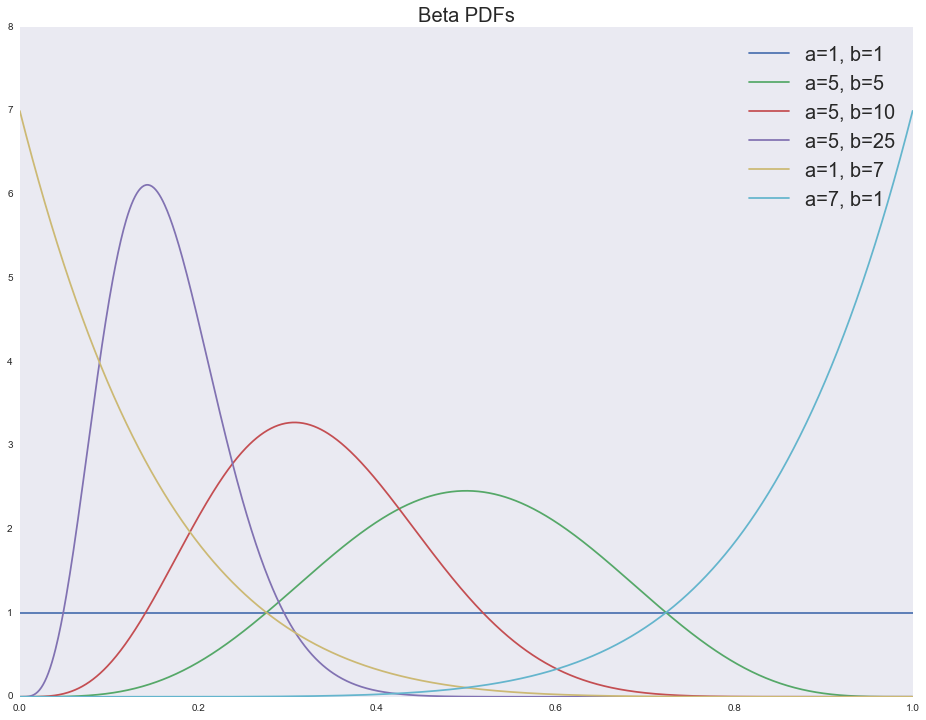

In [14]:
support = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
for a, b in [(1, 1), (5, 5), (5, 10), (5, 25), (1, 7), (7, 1)]:
    ax.plot(support, stats.beta.pdf(support, a, b), 
            label='a=%i, b=%i' % (a, b))
ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('Beta PDFs', fontsize=20)

Получается, что имея некоторые априорные ожидания об истнном значении конверсии, мы можем использовтаь теорему Байеса и обновлять наши ожидания при поступлении новых данных. А форма априорного распределения после обновления ожиданий остается все тем же бета распределением. Итак у нас есть следующая модель:
$$\large\begin{array}{lcr}
\theta_i &\sim& \text{Beta}\left(\alpha_i, \beta_i\right) \\
y_i &\sim& \text{Bernoulli}\left(\theta_i\right)
\end{array}$$

Тут мы применяем вторую, вполне естественную эвристику: давайте может будем для нового пользователя (новый эксперимент) семплировать руку бандита (вариацию кнопки) не случайно, а пропорционально нашим текущим ожиданиям о полезности этой руки. Но так как у нас байесовская постановка задачи, и мы не храним в явном виде наши оценки полезности, а храним распределение оценок полезности для каждой руки, то и алгоритм семплирования немного изменяется:
0. Для всех бандитов введем два параметра бета распределения и приравняем их к единице $\forall i, \alpha_i = \beta_i = 1$;
- повторяем в течении некоторого времени $t = 1, 2, \ldots$ 
  1. для каждого бандита семплируем $\theta_i \sim \text{Beta}\left(\alpha_i, \beta_i\right)$;
  - выбираем бандита с максимальной наградой $k = \arg\max_{i} \theta_i$
  - используем $k$-ого бандита в текущем эксперименте и получаем награду $y \in \left\{0, 1\right\}$ (показываем ту кнопку текущему пользователю, которая по темущему семплу максимизирует награду);
  - обновляем параметры соответствующего априорного распределения (легко мобифицируется для batch mode, если мы проводим не один, а серию экспериментов): 
    - $\alpha_i := \alpha_i + y$
    - $\beta_i := \beta_i + 1 - y$
    

Семплирование Топпсона является эмпирикой, но для некоторых случаев доказанны теоремы ассимптотической сходимости. В том числе и для Beta-Bernoulli случая, т.е. при $t \rightarrow \infty$ вероятность того, что бандиты с семплированием Томпсона сойдутся к верному решению, равна единице. Но это все теории, на практике нам важно следующее:
- если обозначить вероятность выйгрыша на лучшем бандите за $\theta^*$, то доля трафика портаченного на эту опцию будет пропорциональна $\theta^*$; в процессе обучения, точность оценки будет возрастать и доля трафика, потраченного на нужную опцию, будет расти;
<img src="./../images/abvsb.png" />

- в любой момент времени у нас есть параметры распределения вероятностей выйгрыша на каждой вариации (параметры бета распределения), это позволяет нам применять все те же тесты, что и при классическом тестировании;
- но отметим, что в отличие от тестов, мы не хотим получить ответ в виде статистической значимости разности кликов по разным вариациям, мы, как бизнес, хотим максимизировать CTR, а именно это и делает бандитская модель.

It turns out that having some a priori expectations about the true value of the conversion, we can use Bayes' theorem and update our expectations when new data are received. And the form of a priori distribution after updating expectations remains the same beta distribution. So we have the following model:
$$ \ large \ begin {array} {lcr}
\ Theta_i & \ sim & \ text {Beta} \ left (\ alpha_i, \ beta_i \ right) \\
Y_i & \ sim & \ text {Bernoulli} \ left (\ theta_i \ right)
\ End {array} $$

Here we apply a second, quite natural heuristic: let's have a chance for a new user (a new experiment) to sample the bandit's hand (button variation) not by chance, but in proportion to our current expectations about the usefulness of this hand. But since we have a Bayesian formulation of the problem, and we do not explicitly store our utility estimates, but store the distribution of utility estimates for each hand, the sampling algorithm also changes slightly:
0. For all the bandits, we introduce two parameters of the beta distribution and equate them to the unit $ \ forall i, \ alpha_i = \ beta_i = 1 $;
- we repeat for some time $ t = 1, 2, \ ldots $
  1. For each gangster, we sample $ \ theta_i \ sim \ text {Beta} \ left (\ alpha_i, \ beta_i \ right) $;
  - choose the bandit with the maximum reward $ k = \ arg \ max_ {i} \ theta_i $
  - use the $ k $ th bandit in the current experiment and get the reward $ y \ in \ left \ {0, 1 \ right \} $ (show that button to the current user who maximizes the reward for the sample);
  - update the parameters of the corresponding a priori distribution (it is easy to be mobilized for batch mode, if we conduct not one but a series of experiments):
    - $ \ alpha_i: = \ alpha_i + y $
    - $ \ beta_i: = \ beta_i + 1 - y $
    

Toppson's sampling is empirical, but for some cases the theorems of asymptotic convergence are proved. Including for the case of Beta-Bernoulli, i.e. At $ t \ rightarrow \ infty $ the probability that thugs with Thompson sampling will converge to the correct solution is equal to one. But these are all theories, in practice the following is important to us:
- if we denote the probability of winning on the best bandit for $ \ theta ^ * $, then the share of traffic ported to this option will be proportional to $ \ theta ^ * $; In the learning process, the accuracy of the assessment will increase and the proportion of traffic spent on the desired option will grow;
<Img src = "./../ images / abvsb.png" />

- At any given time, we have the parameters of the probability distribution of winnings on each variation (parameters of the beta distribution), this allows us to apply all the same tests as in the classical testing;
- but we note that unlike the tests, we do not want to receive an answer in the form of statistical significance of the difference in clicks for different variations, we, as a business, want to maximize the CTR, which is exactly what the bandit model does.

# Эксперимент
Проведем симуляционный эксперимент. Допустим у нас все те же пять вариаций кнопки, но со временем предпочтения пользователей нашего мурлычного сайта плавно меняются. В принципе, динамика уже сразу исключает применение одного A/B/n теста, ну и ладушки.

# Experiment
We will carry out the simulation experiment. Suppose we have all the same five variations of the button, but over time, the preferences of users of our purr site are smoothly changing. In principle, the dynamics already immediately exclude the use of one A / B / n test, well, the ladushki.

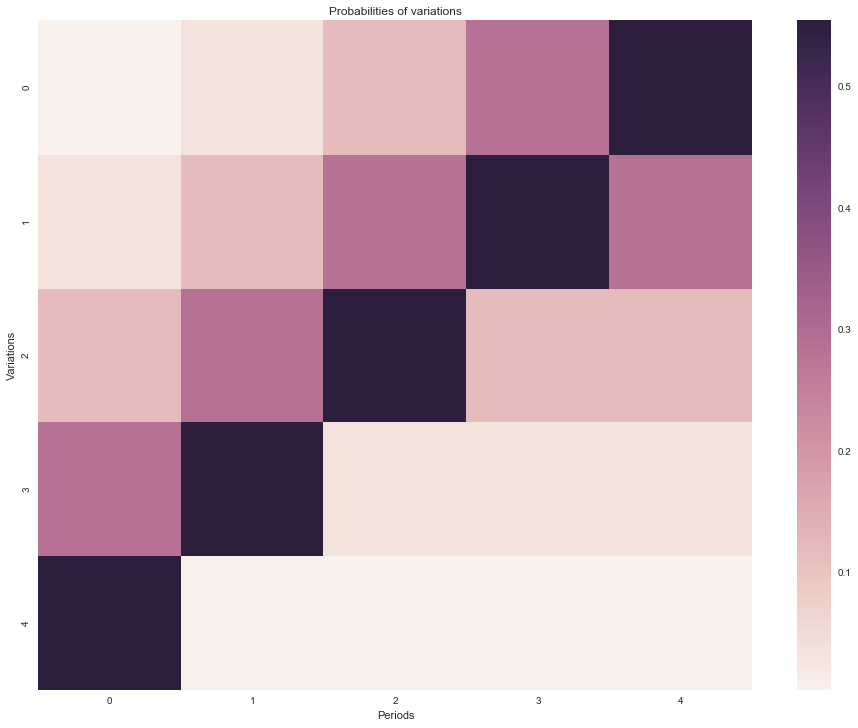

In [15]:
# Number of variations
n_variations = 5

# How many times preferences switch
n_switches = 5

# каждые n_period_len показов кнопки предпочтения пользователей меняются
# Every n_period_lendisplays of a button the preferences of users switch
n_period_len = 2000

# истинные вероятности клика по каждой вариации
# напомню, что длина периода в течении которого тренд не меняется равена n_period_len
# True probabilities of click on every button variation
# The length of a stable trend period is equal to n_period_len
p_true_periods = np.array([
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 1],
        [3, 4, 5, 2, 1],
        [4, 5, 3, 2, 1],
        [5, 4, 3, 2, 1]], dtype=np.float32).T**3
p_true_periods /= p_true_periods.sum(axis=0)

# отрисуем истинные вероятности
# Plot of true probabilities
ax = sns.heatmap(p_true_periods)
ax.set(xlabel='Periods', ylabel='Variations', title='Probabilities of variations')
plt.show()

Теперь запустим симуляцию, будем выводить после каждого периода наши оценки вероятности клика по каждой вариации, и убедимся, что к концу каждого периода находится оптимальная вариация. Так же будем следить за тем, сколько трафика из n_period_len отправлено на каждую вариацию. 

В первый период мы четко определяем победителя (самый правый график с явно выраженным пиком). Но вот во втоой период мы уже приходим не с полной неопрдеделенностью (равномерное распределение на параметры), а со статистикой собранной в первый период, и потому мы видем, что существенная доля трафика уходит на старого победителя. К следующим периодам новым лучшим вариациям все труднее выходить в лидеры, обратите внимание, что дисперсия бывших лидеров (ширина пика) меняется очень медленно. Потому часто алгоритм не успевает за заданное количество шагов сойтись. Существует множество способов исправления этой ситуации, самым простым является постепенное выравнивание распределения (приведение к равномерному, т.е. со временем мы теряем уверенность в прошлых оценках - это вполне естесвтенно). 

Now let's run the simulation, we will output after each period our estimates of the probability of a click on each variation, and make sure that by the end of each period there is an optimal variation. We will also monitor how much traffic from n_period_len is sent to each variation.

In the first period, we clearly define the winner (the rightmost chart with a clearly expressed peak). But in the second period we do not come with complete uncertainty (uniform distribution of parameters), but with statistics collected in the first period, and therefore we see that a significant share of traffic goes to the old winner. To the next periods of the new best variations, it is increasingly difficult to enter the leaders, note that the dispersion of former leaders (peak width) varies very slowly. Therefore, often the algorithm does not have time to converge for a given number of steps. There are many ways to correct this situation, the simplest is the gradual alignment of the distribution (bringing to uniform, ie, we lose confidence in past assessments with time - this is quite natural).

Winner is 4
4    1953
3      19
2      12
1       8
0       8
dtype: int64


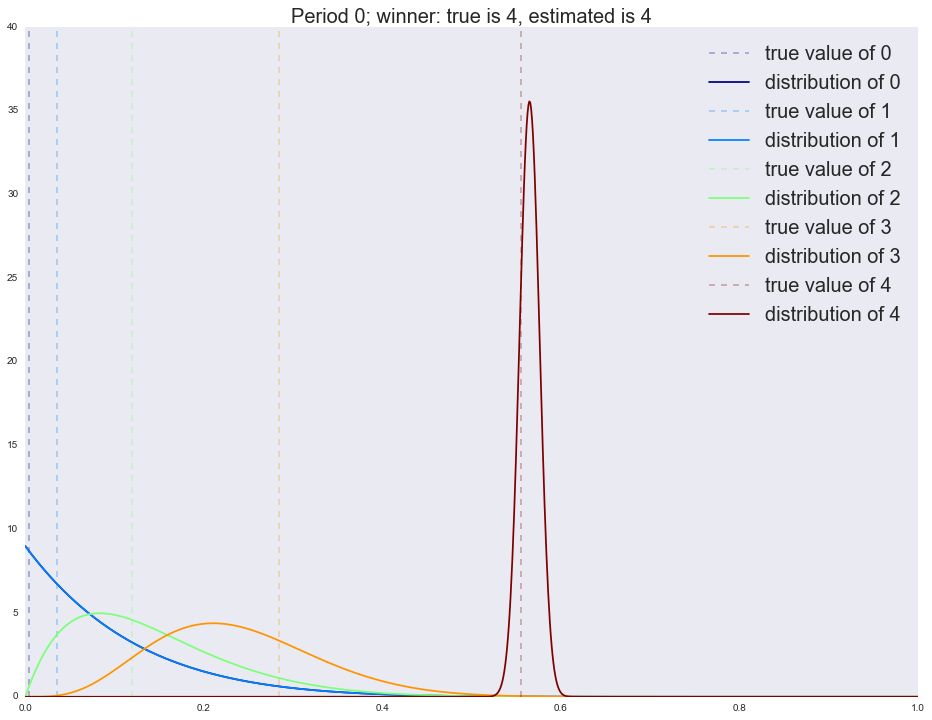

Winner is 4
3    1397
4     593
1       6
2       3
0       1
dtype: int64


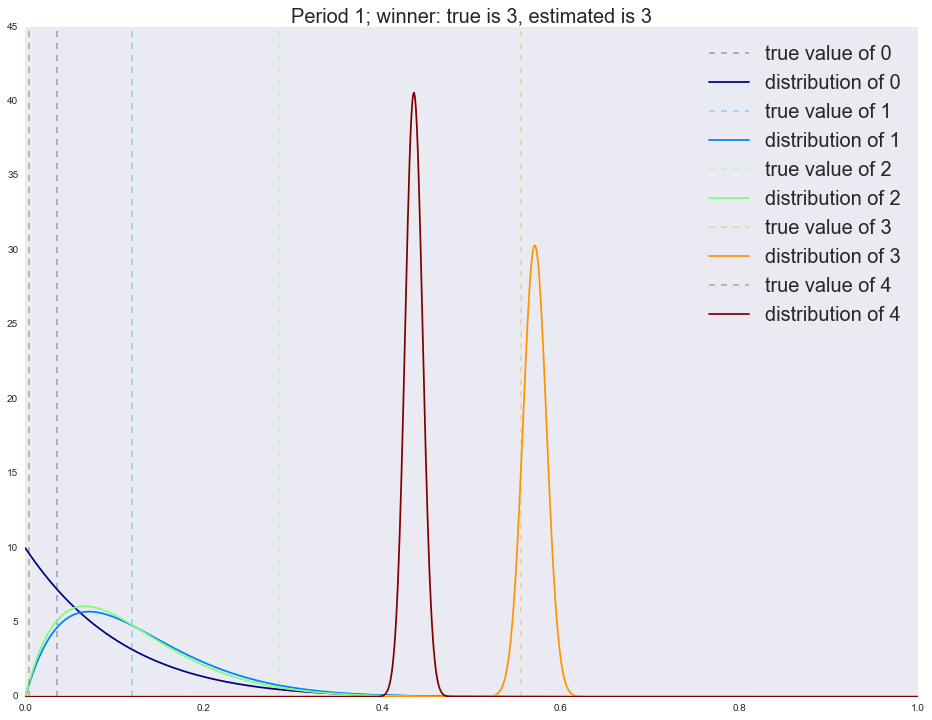

Winner is 4
2    1064
3     675
4     255
1       3
0       3
dtype: int64


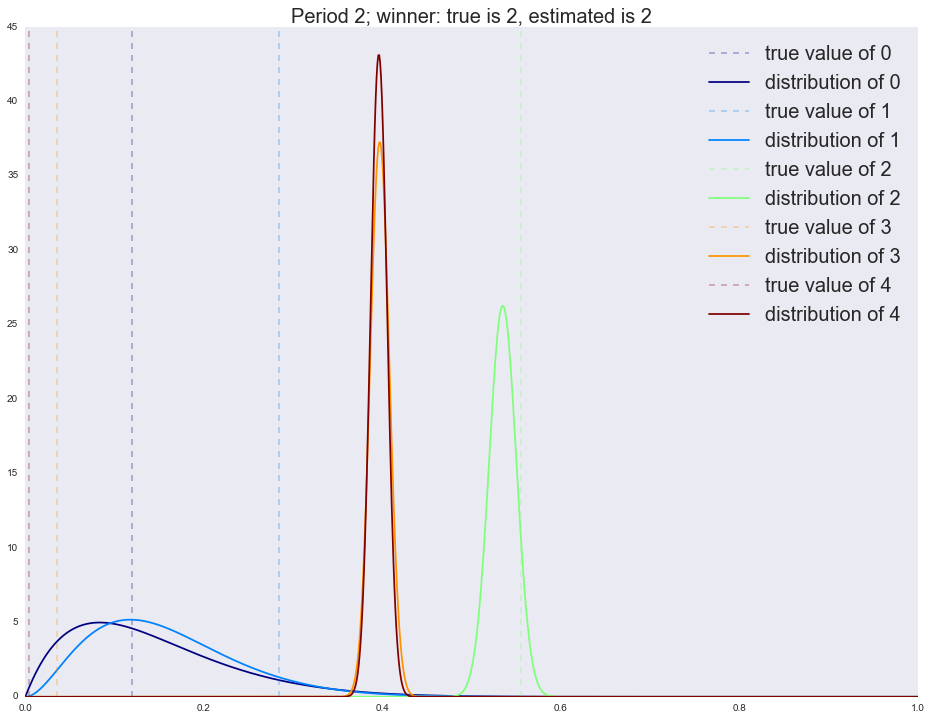

Winner is 4
1    983
2    695
4    144
3    134
0     44
dtype: int64


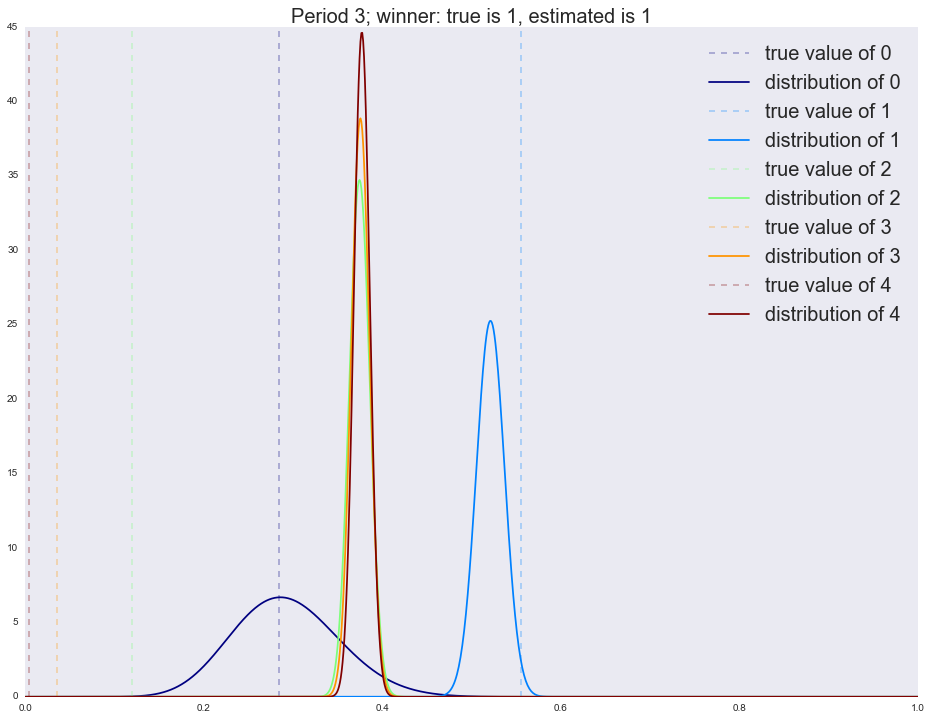

Winner is 4
1    1109
0     888
4       2
2       1
dtype: int64


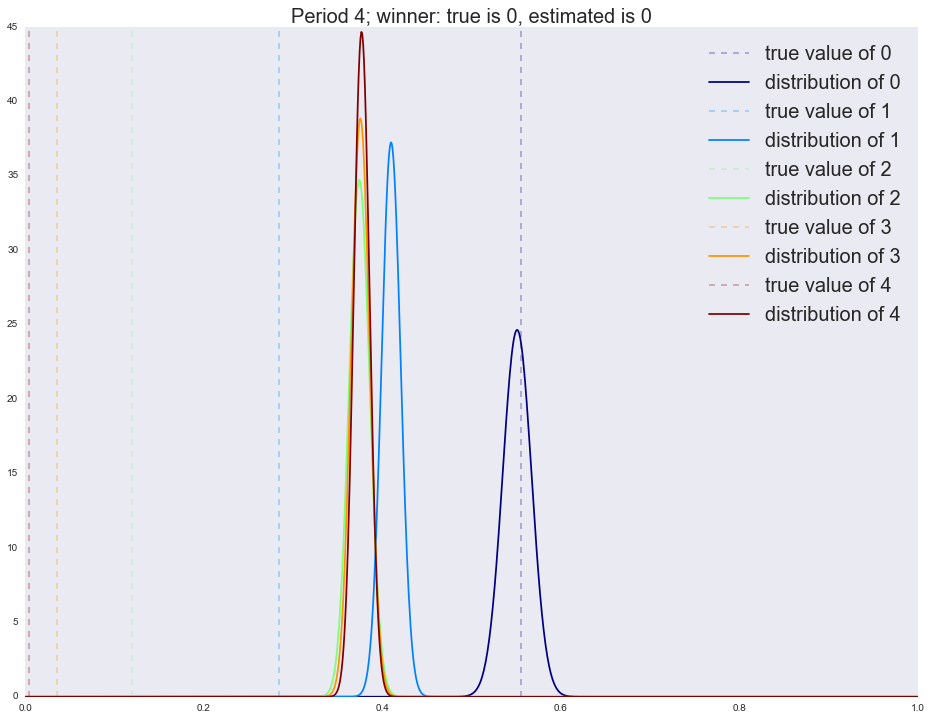

In [16]:
x_support = np.linspace(0, 1, 1000)

alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n_variations)]

actionspp = []

for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in range(n_period_len):
        theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) 
                      for i in range(n_variations)])
        k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
        actions.append(k)
        
        x_k = np.random.binomial(1, p_true[k], size=1)[0]
        
        alpha[k].append(alpha[k][-1] + x_k)
        beta[k].append(beta[k][-1] + 1 - x_k)
    

    expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1])) 
                            for i in range(n_variations)])
    estimated_winner = sorted(expected_reward.items(), 
                              key=lambda t: t[1], 
                              reverse=True)[0][0]

    print 'Winner is %i' % i
    actions_loc = pd.Series(actions).value_counts()
    print actions_loc
    actionspp.append(actions_loc.to_dict())
    
    for i in range(n_variations):
        plt.axvline(x=p_true[i], color=colors[i], linestyle='--', 
                    alpha=0.3, label='true value of %i' % i)
        
        plt.plot(x_support, stats.beta.pdf(x_support, alpha[i][-1], beta[i][-1]), 
                 label='distribution of %i' % i, color=colors[i])
    plt.legend(prop={'size': 20})
    plt.title('Period %i; winner: true is %i, estimated is %i' % 
              (ix_period, 
               p_true.argmax(),
               estimated_winner),
              fontsize=20)
    plt.show()

actionspp = dict(enumerate(actionspp))

Отрисуем долю трафика потраченного на каждую вариацию в каждый период.

We will draw the share of traffic spent for each variation in each period.

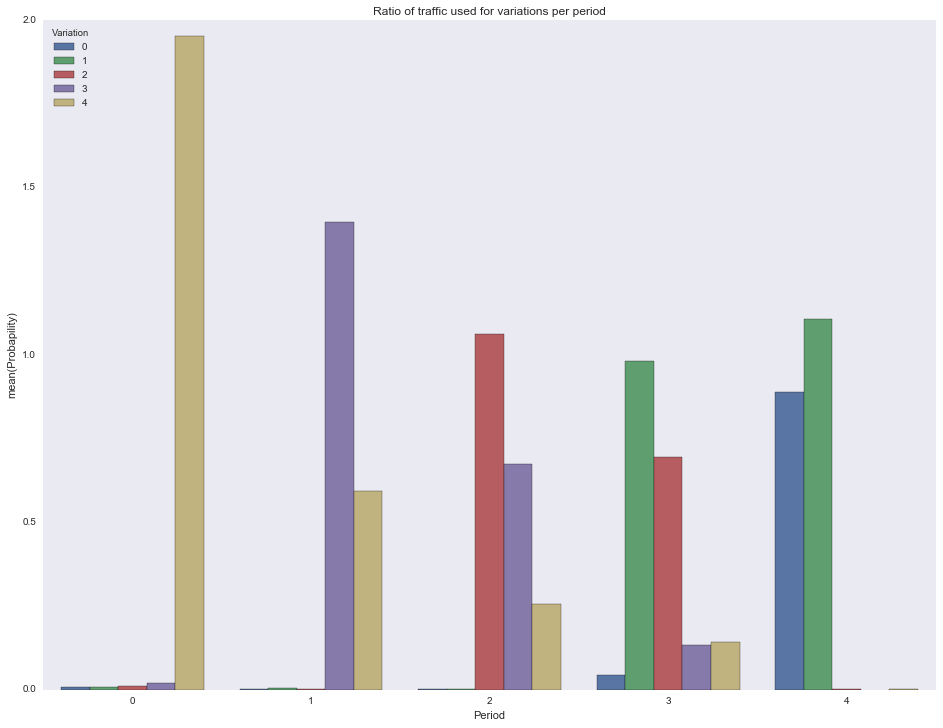

In [17]:
df = []
for pid in actionspp.keys():
    for vid in actionspp[pid].keys():
        df.append({
                'Period': pid,
                'Variation': vid,
                'Probapility': actionspp[pid][vid]/1000.0
            })
df = pd.DataFrame(df)
ax = sns.barplot(x="Period", y="Probapility", hue="Variation", data=df)
ax.set(title="Ratio of traffic used for variations per period")
plt.show()

Ну и под конец нарисуем в динамике изменения наших ожиданий относительно крутости каждой вариации.

In [78]:
n_period_len = 3000

alpha = dict([(i, [1]) for i in range(n_variations)])
beta = dict([(i, [1]) for i in range(n_variations)])
decay = 0.99

plot_step = 25

for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

img_ix = 0
height = 10 # 15
for ix_period in range(p_true_periods.shape[1]):
    p_true = p_true_periods[:, ix_period]
    is_converged = False
    actions = []
    for ix_step in tqdm_notebook(range(n_period_len)):
        if ix_step % plot_step == 0:
            expected_reward = dict([(i, alpha[i][-1]/float(alpha[i][-1] + beta[i][-1])) 
                                    for i in range(n_variations)])
            estimated_winner = sorted(expected_reward.items(), 
                                      key=lambda t: t[1], 
                                      reverse=True)[0][0]

            fig, ax = plt.subplots()
            ax.set_ylim(0, height)
            ax.set_xlim(0, 1)
            for i in range(n_variations):
                ax.axvline(x=p_true[i], color=colors[i], linestyle='--', 
                           alpha=0.3, label='true value of %i' % i)

                ax.plot(x_support, stats.beta.pdf(x_support, alpha[i][-1], beta[i][-1]), 
                        label='distribution of %i' % i, color=colors[i])
            ax.legend(prop={'size': 20})
            ax.set_title('Period %i, step %i; winner: true is %i, estimated is %i' % 
                         (ix_period, 
                          ix_step,
                          p_true.argmax(),
                          estimated_winner),
                         fontsize=20)
            
            fig.savefig('./../images/mab_gif/%i.png' % img_ix, dpi=80)
            img_ix += 1

            plt.close(fig)
        
        
            theta = dict([(i, np.random.beta(alpha[i][-1], beta[i][-1])) 
                          for i in range(n_variations)])
            k, theta_k = sorted(theta.items(), key=lambda t: t[1], reverse=True)[0]
            actions.append(k)

            x_k = np.random.binomial(1, p_true[k], size=1)[0]

            alpha[k].append(alpha[k][-1] + x_k)
            beta[k].append(beta[k][-1] + 1 - x_k)
            
            if decay > 0:
                for i in range(n_variations):
                    if i == k:
                        continue
                    alpha[i].append(max(1, alpha[i][-1]*decay))
                    beta[i].append(max(1, beta[i][-1]*decay))
        
print img_ix






600


In [71]:
for f in glob.glob("./../images/mab_gif/mab.gif"):
    os.remove(f)
!convert -delay 5 $(for i in $(seq 1 1 600); do echo ./../images/mab_gif/$i.png; done) -loop 0 ./../images/mab_gif/mab.gif
for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

convert: unable to open image `./../images/mab_gif/600.png': No such file or directory @ error/blob.c/OpenBlob/2705.
convert: unable to open file `./../images/mab_gif/600.png' @ error/png.c/ReadPNGImage/3925.


In [79]:
for f in glob.glob("./../images/mab_gif/mab_decay.gif"):
    os.remove(f)
!convert -delay 5 $(for i in $(seq 1 1 600); do echo ./../images/mab_gif/$i.png; done) -loop 0 ./../images/mab_gif/mab_decay.gif
for f in glob.glob("./../images/mab_gif/*.png"):
    os.remove(f)

convert: unable to open image `./../images/mab_gif/600.png': No such file or directory @ error/blob.c/OpenBlob/2705.
convert: unable to open file `./../images/mab_gif/600.png' @ error/png.c/ReadPNGImage/3925.


<img src="./../images/mab_gif/mab.gif" />

<img src="./../images/mab_gif/mab_decay.gif" />

Заключение

В заключение, отметим еще несколько преимуществ бандитов для онлайн-экспериментов:

    бандиты позволяют добавлять новые вариации прямо в процессе эксперимента;
    если у вас есть некоторые априорные ожидания о том, что новая вариация лучше остальных, то вы можете добавить ее в эксперимент, изменив ожидания с равномерного распределения 

на смещенное ожидание в сторону единицы
;
в случае, если варианты разнесены по инфраструктуре, и один из сервисов вышел из строя, то бандитская модель быстро это заметит и перестанет лить трафик в сломанную руку.

Самое главное: при использовании бандитов в разы увеличивается количество мурлыкающих котиков, разве это не прекрасно? Все остальные аргументы вообще ничего не стоят.

Conclusion

In conclusion, we note several more advantages of bandits for online experiments:

    Bandits allow you to add new variations right during the experiment;
    If you have some a priori expectations that the new variation is better than the rest, then you can add it to the experiment by changing the expectations with a uniform distribution

To a biased expectation towards unity
;
In the event that the options are spaced across the infrastructure, and one of the services is out of order, then the bandit model will quickly notice it and stop pouring traffic into the broken arm.

Most importantly: when using bandits at times, the number of purring seals increases, is not it wonderful? All other arguments are worthless.